In [1]:
include("src/Retrainer.jl")

Main.Retrainer

/*****************************************************************************/
/                               Retrainer                                     /
/*****************************************************************************/
    
Parameters read from file: input.toml

Neural Network would be changed from:
- File: model-iter-101.bson
- Structure: [8, 30, 30, 30, 1]
- Activations: ["identity", "relu", "relu", "identity"]
- Use bias: true
- Precision: f64
To:
- Saved to file: output_model.bson
- Structure: [8, 10, 8, 1]
- Activations: ["identity", "relu", "identity"]
- Use bias: true
- Precision: f64

Training Parameters:
- Epochs: 20000
- Learning rate: 0.0001
- Optimizer: Adam
- Input Scale Coefficient: 16.0

Testing Parameters:
- Input Scale Coefficient: 16.0
- Samples number: 1000
--------------------------------------------------------------------------------

Iteration 20000: loss = 503174.9106197892e6
Student model error: 0.5815511071670761 ± 1.0067797679364765


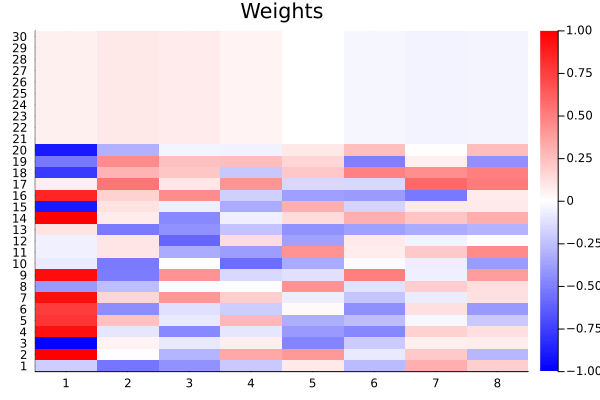

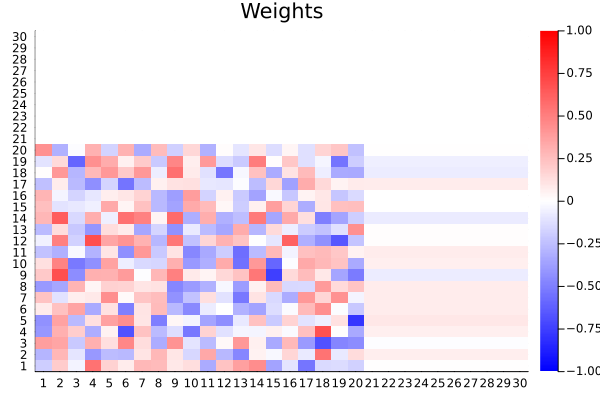

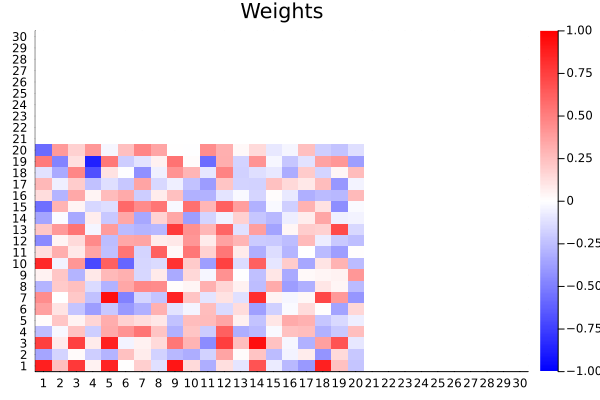

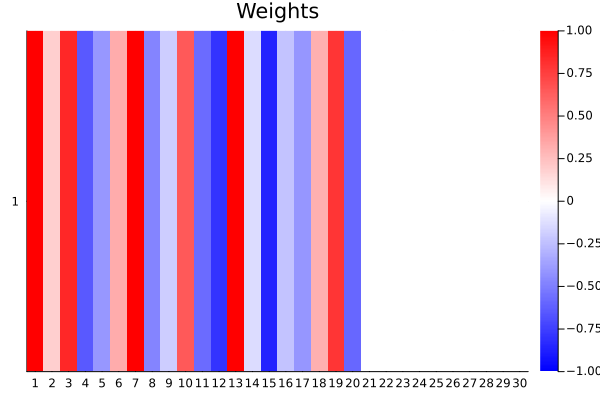

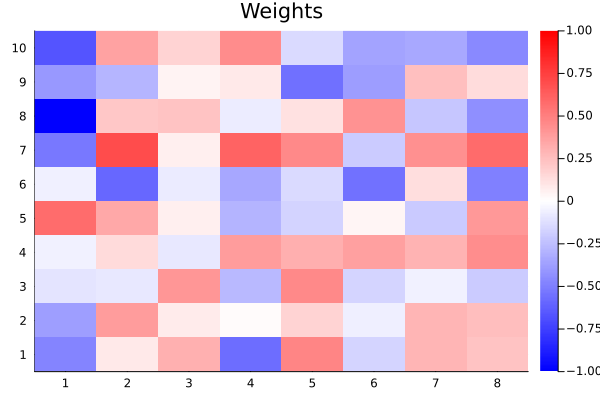

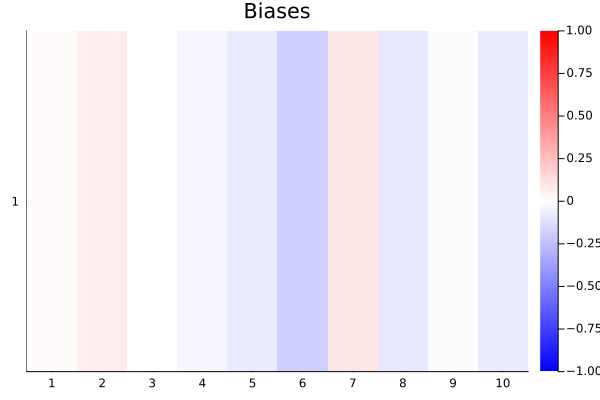

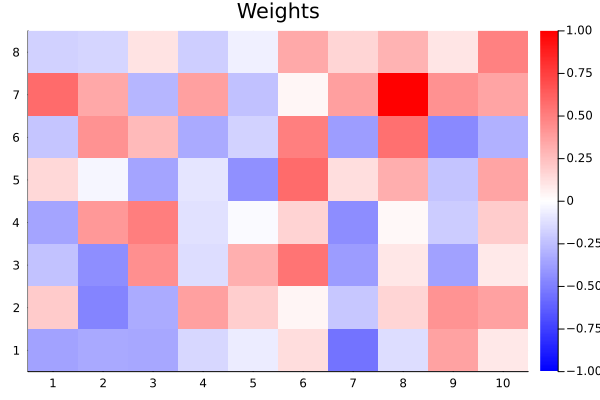

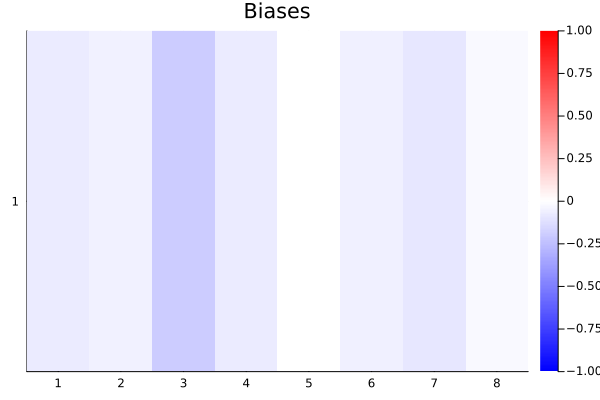

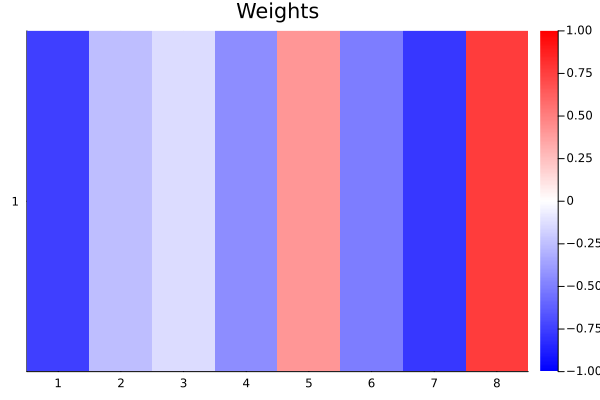

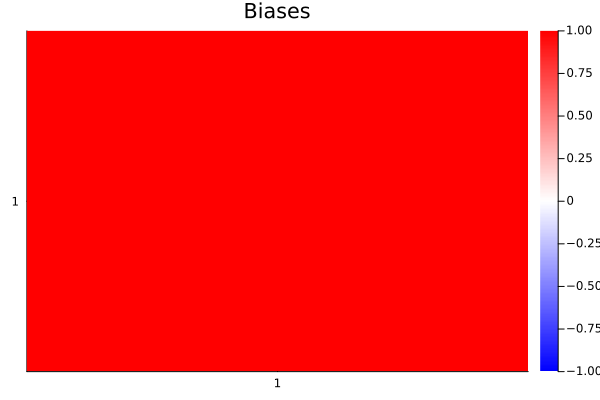

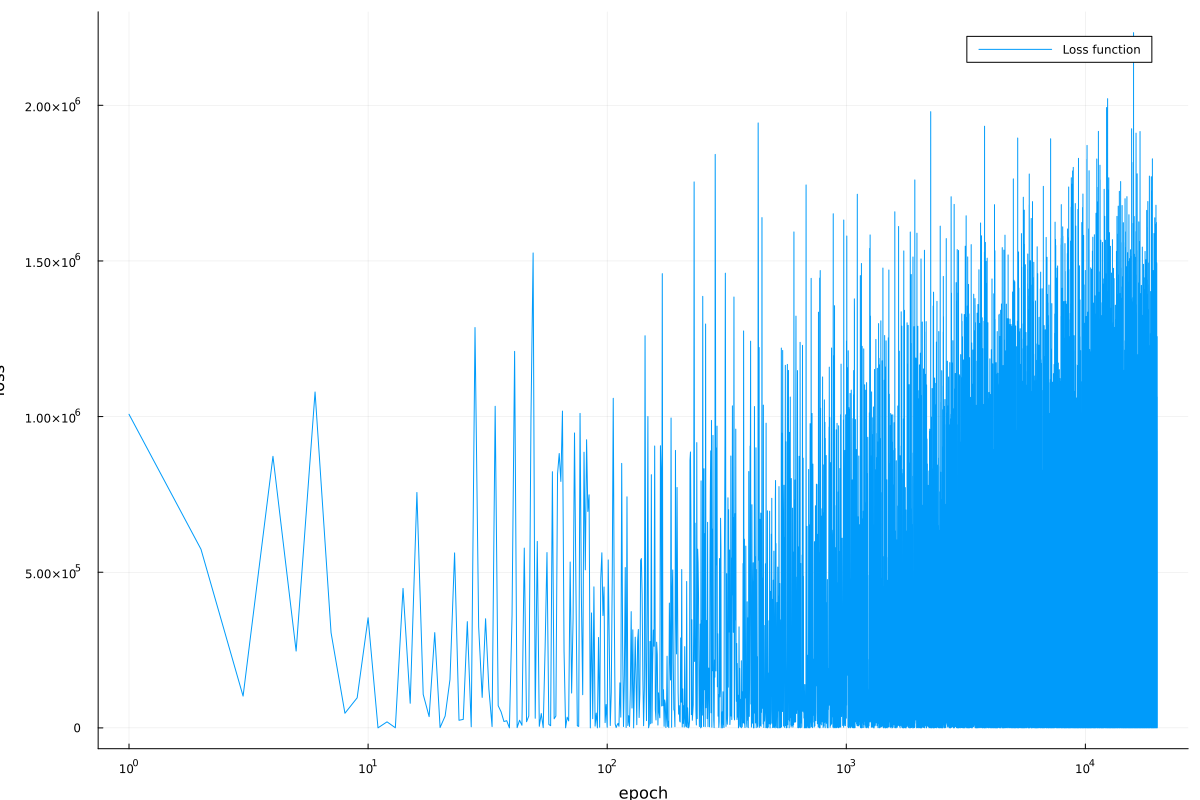

In [2]:
Main.Retrainer.main()